# Lane Detection with OpenCV and Python
## AI.ICT.20221.Group9
- Mai Anh Đức
- Nguyễn Bá Hải
- Đinh Ngọc Khuê
- Trần Phúc Thành


## Code Dependencies

1. [OpenCV 4.5.5](https://opencv.org/releases/): An open-source computer vision library for real-time image and video processing
2. [Python v3.5](https://www.python.org/downloads/): A high-level, interpreted programming language known for its simplicity, code readability, and versatility in various applications
3. [NumPy](http://www.numpy.org/): Numpy makes computing in Python easy. Amount other things it contains a powerful implementation of N-dimensional arrays which we will use for feeding data as input to OpenCV functions.

In [31]:
# Import Required Modules
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Define the path to input images
PATH = "img\input"

# Define an array that contains all input images to choose
data_folder_path = [os.path.join(PATH, image) for image in os.listdir(PATH) if '.jpg' in image]
data_folder_path

['img\\input\\input_00.jpg',
 'img\\input\\input_01.jpg',
 'img\\input\\input_02.jpg',
 'img\\input\\input_03.jpg',
 'img\\input\\input_04.jpg',
 'img\\input\\input_05.jpg',
 'img\\input\\input_06.jpg',
 'img\\input\\input_07.jpg',
 'img\\input\\input_08.jpg']

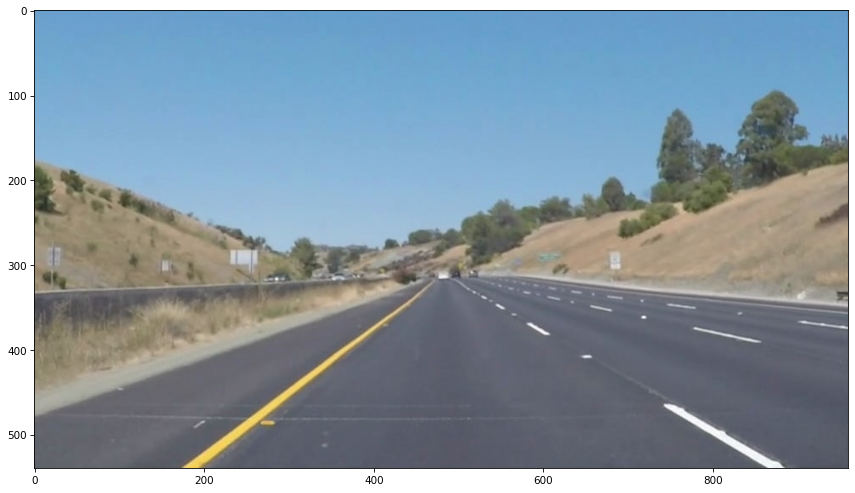

In [33]:
# Read any image in the input images that are in data_folder_path array
img = cv2.imread(data_folder_path[2])

# Display the image
plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

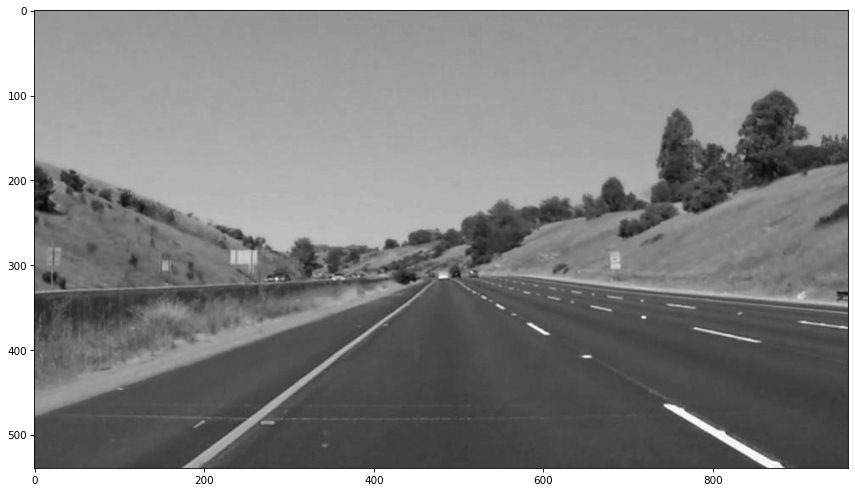

In [34]:
# Convert the image to gray image
image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(image_gray, cmap='gray')

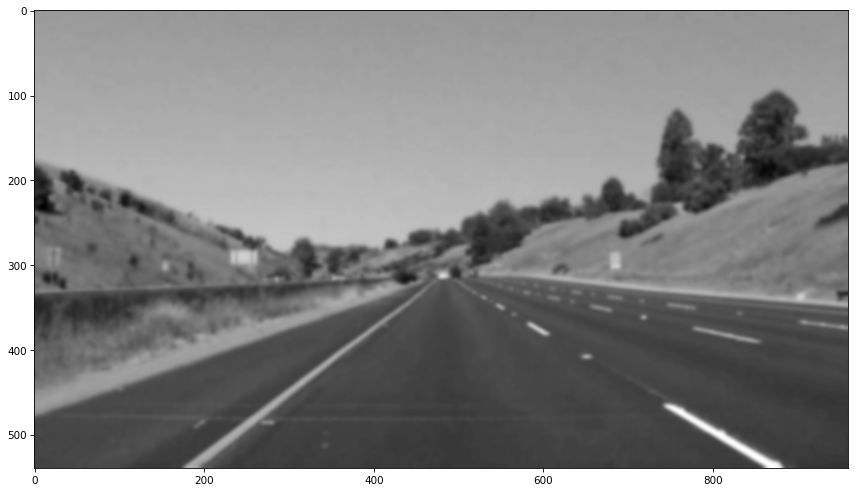

In [35]:
# Blurs an image using a Gaussian filter 
# (input, kernel size, how much to filter, empty)
blurred_img = cv2.GaussianBlur(image_gray, (11, 11), 0)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(blurred_img, cmap='gray')

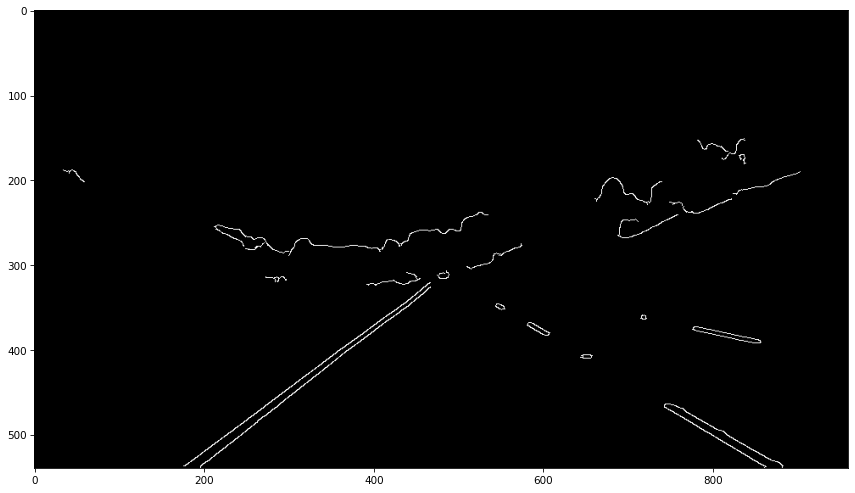

In [36]:
# Canny edge detection
cannied_img = cv2.Canny(blurred_img, 50, 150)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(cannied_img, cmap='gray')

## Helper Functions

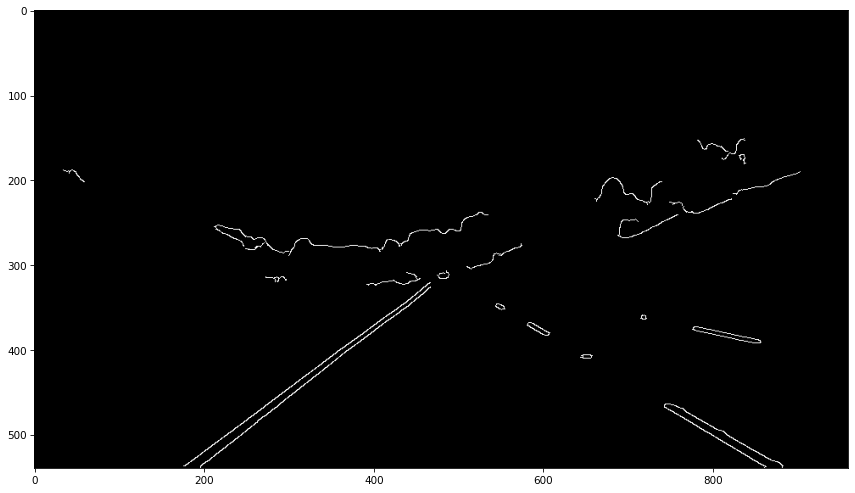

In [37]:
# Grab all above functions as get_canny
def get_canny(img):
    """
    Input: take a raw image
    Output: detect edges of img using canny
    """
    # Convert the image to gray image
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Blurs an image using a Gaussian filter
    image_blur = cv2.GaussianBlur(image_gray, (11, 11), 0)

    # Canny edge detection
    image_canny = cv2.Canny(image_blur, 50, 150)
    return image_canny


canny = get_canny(img)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(cannied_img, cmap='gray')

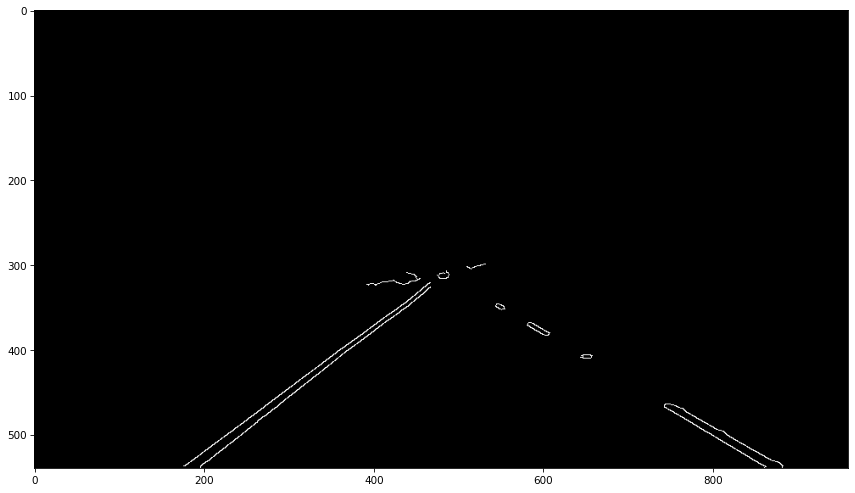

In [38]:
def region_of_interest(img):
    """
    Only keeps the region of the image defined by a polygon
    -----------------------------------------------------
    Input: get a edge image, vertices as the limit of ROI
    Output: A mask of image which only contains ROI
    """
    height = img.shape[0]
    width = img.shape[1]
    polygon = np.array([[(width, height), (int(width / 2), int(height / 2)), (0, height)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, polygon, 255)
    image_mask = cv2.bitwise_and(img, mask)
    return image_mask


image_mask = region_of_interest(cannied_img)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(image_mask, cmap='gray')

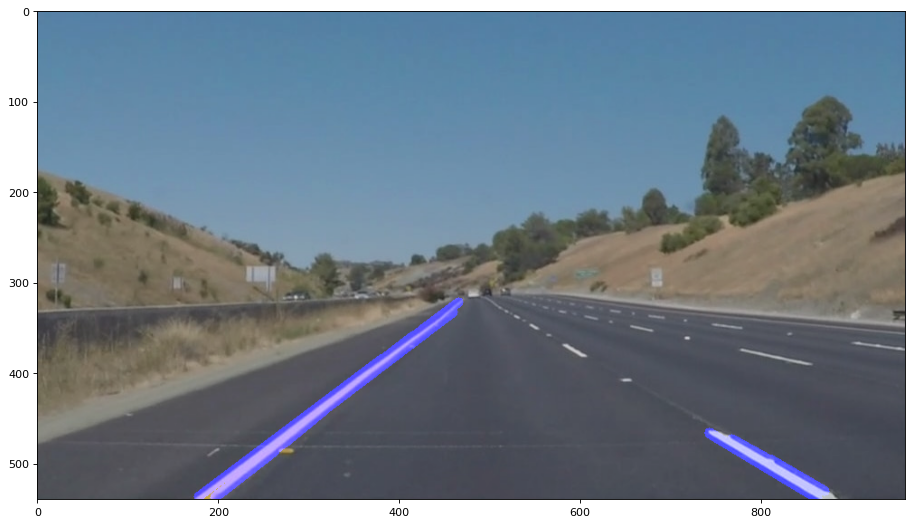

In [39]:
def draw_lines(img, lines):
    image_line = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4, 1)
            cv2.line(image_line, (int (x1) , int (y1)), (int (x2), int (y2)), (255, 0, 0), 10)
    image_combine_line = cv2.addWeighted(img, 0.8, image_line, 1, 1)
    return image_combine_line

# Use function HoughLinesP() to detect lines in an image
lines = cv2.HoughLinesP(image_mask, 2, np.pi/180, 50, np.array([]), minLineLength=40, maxLineGap=5)

# Draw detected lines in the image
image_line = draw_lines(img, lines)
    
plt.figure(figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(image_line, cv2.COLOR_BGR2RGB))

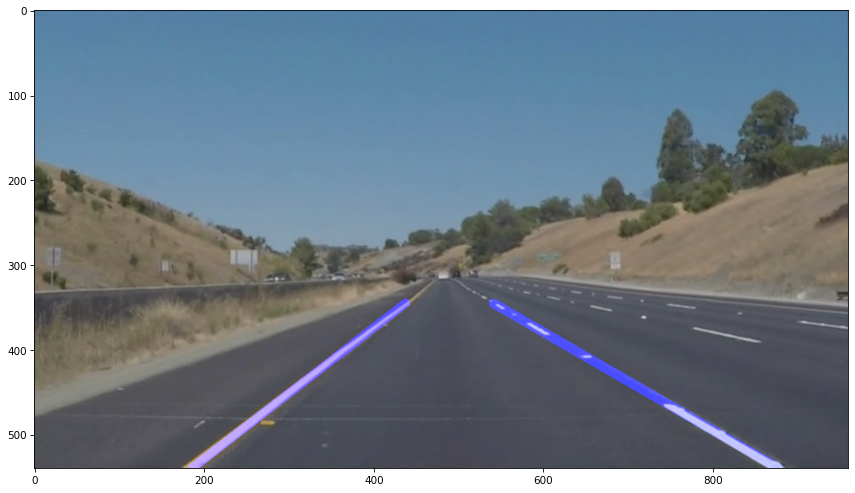

In [40]:
def find_intersection_point(left, right):
    """
    The intersection point between 2 vectors satisfies:
        y = left_slope * x + left_intercept
        y = right_slope * x + right_intercept
    => Intersection point:
        x = (right_intercept - left_intercept) / (left_slope - right_slope)
        y = left_slope * x + left_intercept
    """

    try:
        left_slope, left_intercept = left
    except TypeError:
        left_slope, left_intercept = 0, 0

    try:
        right_slope, right_intercept = right
    except TypeError:
        right_slope, right_intercept = 0, 0
    x = (right_intercept - left_intercept) / (left_slope - right_slope)
    y = left_slope * x + left_intercept
    return np.array([x, y])

def make_coordinates(intersection_point, line_params):
    try:
        slope, intercept = line_params
    except TypeError:
        slope, intercept = 0, 0
    y1 = img.shape[0]
    y2 = int(intersection_point[1] * 100 / 90)
    if (slope == 0):
        x1 = img.shape[0]
        x2 = int(intersection_point[0] * 100 / 90)
    else:
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])


def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []

    """
    Merge detected lines which on the same lane
    And cover the full length of the lanes.
    """
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        params = np.polyfit((x1, x2), (y1, y2), 1)
        slope = params[0]
        intercept = params[1]
        """
        Line that goes through 2 points (x1, y1), (x2, y2):
        y = slope * x + intercept
        => If (slope < 0), this line belongs to the left border
           Else it belongs to the right border
        """
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))

    # Find the line goes through all lines
    left_fit_avg = np.average(left_fit, axis=0)
    right_fit_avg = np.average(right_fit, axis=0)

    # Find the intersection point between left line vector and right line vector
    intersection_point = find_intersection_point(left_fit_avg, right_fit_avg)

    """
    Extend lines' length from bottom of the original 
    image to the 90% of intersection point's length
    """
    left_line = make_coordinates(intersection_point, left_fit_avg)
    right_line = make_coordinates(intersection_point, right_fit_avg)

    return np.array([left_line, right_line])

avg_line = average_slope_intercept(img, lines)
image_line = draw_lines(img, avg_line)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(image_line, cv2.COLOR_BGR2RGB))

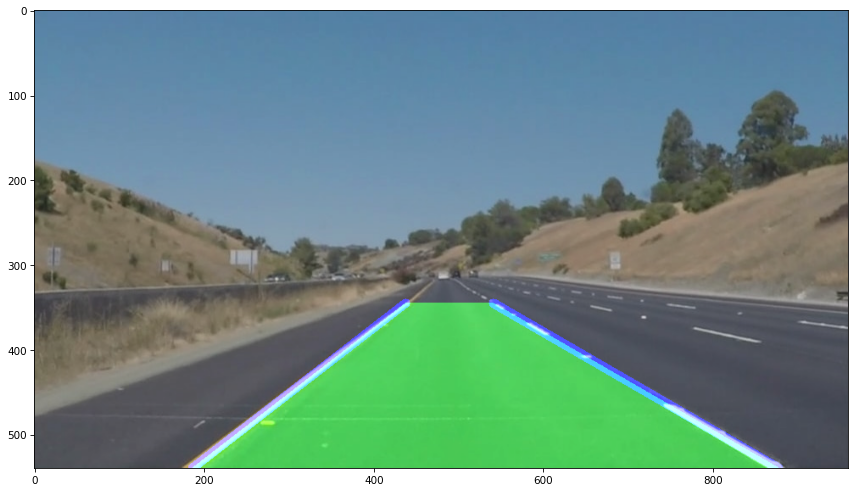

In [41]:
def draw_lane(img, lines):
    image_lane = np.zeros_like(img)
    points_list = np.array(avg_line, np.int32).reshape((4, 2))
    points_list = np.array([points_list[0], points_list[1], points_list[3], points_list[2]])
    cv2.fillPoly(image_lane, [points_list], (0, 255, 0))
    image_combine_lane = cv2.addWeighted(image_line, 1, image_lane, 0.5, 1)
    return image_combine_lane

image_lane = draw_lane(image_line, avg_line)

plt.figure(figsize=(14, 14), dpi=75, facecolor='w', edgecolor='k')
plt.imshow(cv2.cvtColor(image_lane, cv2.COLOR_BGR2RGB))

# Some results

*Success*
![succeed](image_data/output/output_02.png)
![succeed](image_data/output/output_05.png)
![succeed](image_data/output/output_06.png)
![succeed](image_data/output/output_07.png)


*Fail*
![fail](image_data/output/output_01.png)
![fail](image_data/output/output_03.png)
![fail](image_data/output/output_04.png)